## Modeling news article as graph. 

This notebook experiments with some possibilities for modeling the news articles as graphs in a way that their most important keyphrases are easily extracted. 

First graph representation is inspired by **TextRank** (https://www.aclweb.org/anthology/W04-3252/). The nodes in the graph represent the token or noun chunks. The edge is drawn between the tokens if they occur together in the window of 3 words. The number 3 is chosen empirically and can be modified. In the original paper it is 5, however, when the noun chunks, which usuall consist of at least 2 words, are used for vocabulary, the window size should be reduced.

The second model is based on **TopicRank** (https://www.aclweb.org/anthology/I13-1062/). Here the nodes are clustered topics, not separated chunks or words. The units are clustered into one topic (node) if similarity between their vectors is 0.8 or larger. The clustered nodes are then connected with the edge, if words of these clusters (topic) co-occur close enough in the text. The edge is also weighted by the sum of the distances between the words.

The code in this notebook does not precisely follow the papers, but rather takes directions from them. For instance, instead of 25% overlap like in **TopicRank**, the cosine similarity between the word vectors is used to determine if they belong to the same topic (node). Another part that is different is the node metrics computation. In the papers only PageRank algorithm is considered. In the code the ranking of keyphrases is performed and analysed through different centrality algorithms.

In [5]:
import os
import numpy as np
import pandas as pd
import string
import re
from itertools import chain
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [6]:
import networkx as nx
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
from collections import OrderedDict

In [8]:
punct_translator = str.maketrans('', '', string.punctuation)

In [9]:
import spacy
nlp = spacy.load('en_core_web_md')

Reading the data.

In [15]:
news = pd.read_json('../../../KEDatasets/KPTimes/KPTimes.train.jsonl', lines=True)

In [16]:
news.head(2)

,id,categories,date,title,abstract,keyword
0,ny0282969,"[us, politics]",2016-07-21,"For Donald Trump’s Big Speech, an Added Pressu...","CLEVELAND — Until Monday night, Donald J. Trum...",2016 Presidential Election;Donald Trump;Republ...
1,ny0225578,"[sports, hockey]",2010-10-16,"In Home Opener, Rangers Lose Gaborik and Drury...",There were silver linings to the Rangers ’ wil...,Hockey Ice;Toronto Maple Leafs;New York Ranger...


The original file contains 259923 new articles of various lengths in English .

In [17]:
news.shape

(259923, 6)

In [18]:
news[set(news.columns)-{'categories'}].duplicated().sum()

0

Which keyphrases are the most popular in the dataset?

In [19]:
news['keyword'] = news['keyword'].str.split(';')

In [20]:
news = news.explode('keyword')

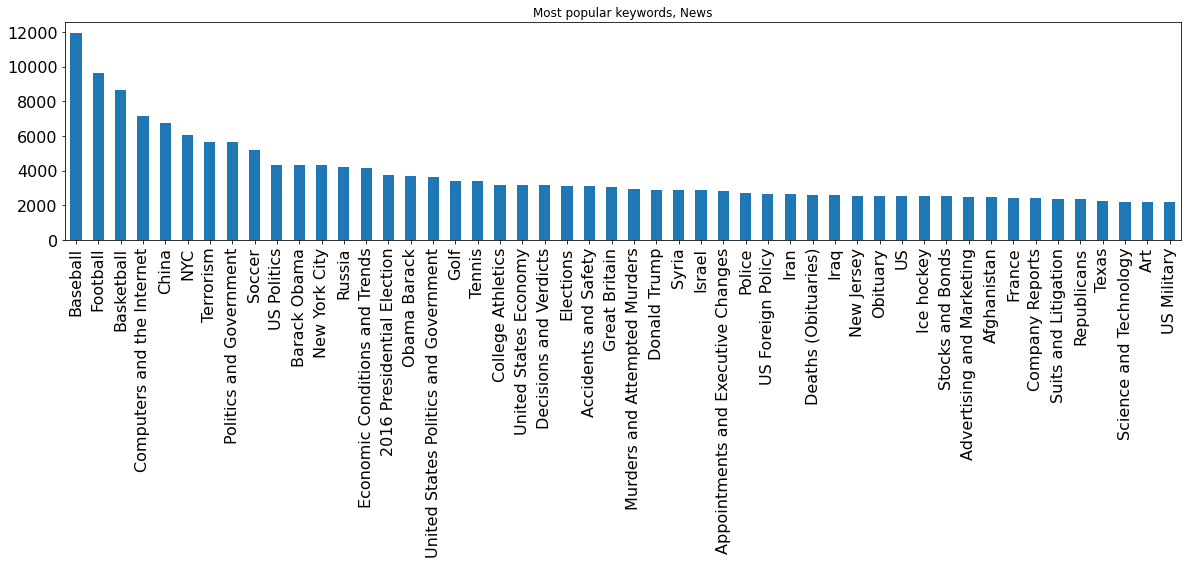

In [21]:
news['keyword'].value_counts().nlargest(50).plot(kind='bar', 
                                                 figsize=(20, 4),
                                                 title='Most popular keywords, News',
                                                 fontsize=16
                                            );

It looks like most of the articles are dedicated to sport, e.g. *Baseball, Football* or *Basketball*. These should be considered when the keyphrases are ranked throughout the whole dataset in the end.

### Visualising the graph of words

In the next few cells a graph visualisation with Bokeh is tested. First, 20 random articles are chosen from the data. Nodes are chosen to be either unique words or noun chunks. They are connected if they appear in the same article. 

In [22]:
np.random.seed(1)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [24]:
ndf = news.groupby('abstract').agg({'keyword':list}).reset_index()

In [25]:
ndf['abstract'].duplicated().sum(), ndf.shape

(0, (259902, 2))

Cleaning the text from stop words and punctuation signs.

In [26]:
signs = string.punctuation + '’“”—\uf021\ufeff¶‘‘■0123456789§$'
translator = str.maketrans(dict([(s, ' ') for s in signs]))
stops = ENGLISH_STOP_WORDS

def clean_text(x):
    
    words = str(x).lower().translate(translator).split()
    return ' '.join([w for w in words if w not in stops])

In [27]:
%time ndf['clean_text'] = ndf.loc[:, 'abstract'].apply(clean_text)

CPU times: user 1min 32s, sys: 38.4 ms, total: 1min 32s
Wall time: 1min 32s


In [28]:
chars = re.compile(r'[^\x00-\x7F]')

In [29]:
ndf = ndf[~ndf['clean_text'].str.contains(chars)].reset_index(drop=True)

In [30]:
ids = np.random.choice(range(len(ndf)), 20, replace=False)

In [31]:
df = ndf.loc[ids].copy()

In [32]:
df.shape

(20, 3)

Computing noun chunks (nodes).

In [33]:
def get_nchunks(x):
    nchunks = []
    #import pdb;pdb.set_trace()
    chunks = nlp(x).noun_chunks
    nchunks = [(c.text.lower(), (c.start_char, c.end_char)) 
               for c in chunks if c.text.lower() not in ENGLISH_STOP_WORDS]

    return nchunks

In [34]:
%time df['nchunks'] = df.loc[:, 'abstract'].apply(get_nchunks)

CPU times: user 1.94 s, sys: 16.1 ms, total: 1.96 s
Wall time: 1.97 s


In [35]:
df = df.explode('nchunks')

In [36]:
df['word_chunks'] = df.loc[:, 'nchunks'].apply(lambda x: x[0])

In [37]:
df = df[df['word_chunks'].str.len() > 2].reset_index()

Plotting a distribution of the lenghts of the computed noun chunks.

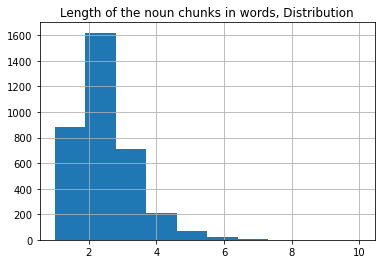

In [38]:
df['word_chunks'].str.split().str.len().hist()
plt.title('Length of the noun chunks in words, Distribution');

Most of the noun chunks are of the length 2, 1, or there. There are, however, some outliers. The assumption is that those very long noun chunks are not going to be very well connected to the rest of the nodes in the graph. On the other hand, very popular words (not only stop words), like *said*, *years*, *guys* etc. should have one of the highest degrees. These might create a problem when the importance of each nodes with respect to keyphrases extraction is defined. 

In [39]:
dfc = df.copy()

In [40]:
dfc = dfc.groupby('abstract').agg({'word_chunks': list}).reset_index()

In [41]:
vocabulary = dfc.explode('word_chunks')['word_chunks'].unique().tolist()

Constructing the coocurrence matrix.

In [42]:
rows = []
array = dfc['abstract'].values
for row in array:
    s = row.lower()
    mask = [w in s for w in vocabulary]
    rows.append(mask)

In [43]:
len(rows), len(rows[0]), len(vocabulary)

(20, 2644, 2644)

In [44]:
docs = np.array(rows, dtype='float')

In [45]:
matrix = np.matmul(docs.T, docs)

In [46]:
matrix.shape

(2644, 2644)

In [47]:
matrix[matrix > 1] = 1

In [48]:
np.fill_diagonal(matrix, 0)

In [49]:
dm = pd.DataFrame(matrix, columns=vocabulary, index=vocabulary)

In [50]:
def get_edges(words):
    edges = []
    for w in words:
        neighbours = dm.loc[dm.loc[w] == 1].index.tolist()
        edges.extend(list(zip([w]*len(neighbours), neighbours)))
        
    return edges

Building a graph of 20 articles.

In [51]:
import networkx as nx

In [52]:
G = nx.Graph()
G.add_nodes_from(vocabulary)

In [53]:
edges = get_edges(vocabulary)
G.add_edges_from(edges)

In [54]:
len(G.edges)

362811

In [55]:
from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

Plotting distribution of nodes degrees.

In [56]:
degrees = [G.degree[n] for n in G.nodes]

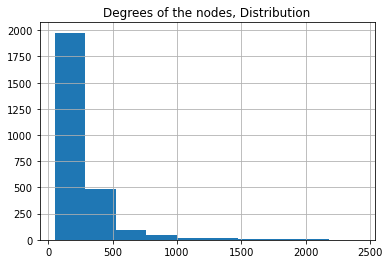

In [57]:
pd.Series(degrees).hist()
plt.title('Degrees of the nodes, Distribution');

The degrees have various values, but most of the nodes have less than 250 connections.

In [58]:
attrs = {n: {"chunk": n, "degree": G.degree[n]} for n in G.nodes}

nx.set_node_attributes(G, attrs)

Plotting the graph.

In [59]:
# Show with Bokeh
plot = Plot(plot_width=1500, plot_height=1000,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Graph Interaction Demonstration"

node_hover_tool = HoverTool(tooltips=[("chunk", "@index"), ("degree", "@degree")])
plot.add_tools(
    node_hover_tool, 
    BoxZoomTool(), 
    ResetTool()
)

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(
    size=15, 
    fill_color=Spectral4[0]
)
#graph_renderer.edge_renderer.glyph = MultiLine(
#    line_color="edge_color", 
#    line_alpha=0.8, 
#    line_width=1
#)
plot.renderers.append(graph_renderer)

#output_file("interactive_graphs.html")
show(plot)

#### Calculating graph metrics for the news dataset. Treating each article as a separated graph in order to understand what model would suit best for a single text.

In [60]:
topics = ['Terrorism', 'NYC', 'TV', 'Baseball', 'Science and Technology']
ndf2 = ndf.explode('keyword')
ids0 = np.random.choice(ndf2.loc[ndf2['keyword'] == 'Terrorism'].index, 20, replace=False).tolist()
ids1 = np.random.choice(ndf2.loc[ndf2['keyword'] == 'NYC'].index, 20, replace=False).tolist()
ids2 = np.random.choice(ndf2.loc[ndf2['keyword'] == 'TV'].index, 20, replace=False).tolist()
ids3 = np.random.choice(ndf2.loc[ndf2['keyword'] == 'Baseball'].index, 20, replace=False).tolist()
ids4 = np.random.choice(ndf2.loc[ndf2['keyword'] == 'Science and Technology'].index, 20, replace=False).tolist()

In [61]:
ids100 = ids0 + ids1 + ids2 + ids3 + ids4

In [62]:
chs = ndf.loc[ids100].reset_index(drop=True)

In [63]:
chs.shape

(100, 3)

In [64]:
chs.head(2)

,abstract,keyword,clean_text
0,CAIRO — President Abdel Fattah el-Sisi of Egyp...,"[Abdel Fattah el-Sisi, Egypt, Immunity from Pr...",cairo president abdel fattah el sisi egypt iss...
1,TEHRAN — A bombing on Wednesday killed 10 peop...,"[Iran, Terrorism]",tehran bombing wednesday killed people women c...


In [65]:
udf = chs.groupby('abstract').agg({'keyword':list, 'clean_text': 'first'})

In [66]:
udf = udf.reset_index()

In [67]:
%time udf['nchunks'] = udf.loc[:, 'abstract'].apply(get_nchunks)

CPU times: user 8.73 s, sys: 15.5 ms, total: 8.75 s
Wall time: 8.75 s


In [68]:
udf.head(1)

,abstract,keyword,clean_text,nchunks
0,A Bronx woman was fatally shot and two of her ...,"[[Murders and Homicides, Walikque Faussett, NY...",bronx woman fatally shot friends wounded early...,"[(a bronx woman, (0, 13)), (her friends, (42, ..."


Computing vocabulary, nodes, edges and creating a co-occurance graph for each article.

In [69]:
punct_translator = str.maketrans('', '', string.punctuation)
def make_vocab(x):
    nchunks = x[3]
    #import pdb;pdb.set_trace()
    ss = x[0].lower()
    #print(ss)
    spans = list(list(zip(*nchunks))[1])
    keys = list(list(zip(*nchunks))[0])
    spans.extend([(len(ss),)])
    keys_ids = list(zip(keys, list(zip(*spans))[0]))
    non_chunks = [(ss[0:spans[0][0]], 0)]+[(ss[spans[i][-1]:spans[i+1][0]-1], spans[i][-1])
                                      for i in range(len(spans)-1)]
    non_chunks.extend(keys_ids)
    #print(non_chunks)
    words = list(zip(*sorted(non_chunks, key=lambda x: x[1])))[0]
    #print(words)
    vocab = []
    for w in words:
        if w not in keys:
            w = w.translate(punct_translator).lower().split()
            for i in w:
                if i not in ['', ' ', '  ', '   ']:
                    vocab.append(i)
        else: vocab.append(w)
    return vocab


def get_edges(ordered_vocab, size=3):
    edges = {w: set() for w in ordered_vocab}

    for i in range(len(ordered_vocab)):
        start = i-size if i >= size else 0
        end = i+size if i+size < len(ordered_vocab) else len(ordered_vocab)-1
        nodes = {ordered_vocab[j] for j in range(start, end+1) if i != j}
        edges[ordered_vocab[i]].update(nodes)
    groups = [list(zip([i]*len(edges[i]), edges[i])) for i in edges]
    edges = list(chain.from_iterable(groups))
    
    return edges

def show_bokeh_graph(vocab, G, text, degree):
    plot = Plot(plot_width=1500, plot_height=1000,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = ' '.join(vocab)

    node_hover_tool = HoverTool(
        tooltips=[("text", "@{}".format(text)), 
                  ("degree", "@{}".format(degree))]
    )
    plot.add_tools(
        node_hover_tool, 
        BoxZoomTool(), 
        ResetTool()
    )

    graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

    graph_renderer.node_renderer.glyph = Circle(
        size=15, 
        fill_color=Spectral4[0]
    )
    #graph_renderer.edge_renderer.glyph = MultiLine(
    #    line_color="edge_color", 
    #    line_alpha=0.8, 
    #    line_width=1
    #)
    plot.renderers.append(graph_renderer)

    #output_file("interactive_graphs.html")
    show(plot)

def make_coocGraph(v):
    G = nx.Graph()
    edges = get_edges(v)
    G.add_nodes_from(set(v))
    G.add_edges_from(edges)
    G_attrs = {n: {"text": n , 
                   "degree": G.degree[n]}
            for n in G.nodes}

    nx.set_node_attributes(G, G_attrs) 
    return G

In [70]:
%time udf['vocab'] = udf.apply(make_vocab, axis=1)

CPU times: user 98.9 ms, sys: 118 µs, total: 99 ms
Wall time: 98.8 ms


In [71]:
%time udf['vocab_len'] = udf.loc[:, 'vocab'].apply(lambda x: len(set(x)))

CPU times: user 5.81 ms, sys: 0 ns, total: 5.81 ms
Wall time: 5.61 ms


In [72]:
%time udf['graph'] = udf.loc[:, 'vocab'].apply(make_coocGraph)

CPU times: user 455 ms, sys: 12 ms, total: 467 ms
Wall time: 466 ms


In [73]:
udf.head(1)

,abstract,keyword,clean_text,nchunks,vocab,vocab_len,graph
0,A Bronx woman was fatally shot and two of her ...,"[[Murders and Homicides, Walikque Faussett, NY...",bronx woman fatally shot friends wounded early...,"[(a bronx woman, (0, 13)), (her friends, (42, ...","[a bronx woman, was, fatally, shot, and, two, ...",174,"(two, the flatiron district, the three women, ..."


## Computing graph metrics for co-occurence model

### Average shortest path length

In [74]:
%%time
udf['av_shortest_path_len'] = (udf.loc[:, 'graph']
                               .apply(
                                   lambda x: nx.average_shortest_path_length(x)))

CPU times: user 10.8 s, sys: 0 ns, total: 10.8 s
Wall time: 10.8 s


### Average clustering coefficient and clustering coefficient for each node of the graph

In [75]:
%%time
udf['clustering'] = (udf.loc[:, 'graph']
                     .apply(lambda x: nx.clustering(x)))

CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.05 s


In [76]:
%%time
udf['average_clustering'] = (udf.loc[:, 'clustering']
                             .apply(lambda x: np.mean(list(x.values()))))

CPU times: user 3.75 ms, sys: 0 ns, total: 3.75 ms
Wall time: 3.38 ms


# Node metrics for co-occurence model (Centrality)

### VoteRank

In [77]:
%%time
udf['vote_rank'] = (udf.loc[:, 'graph']
                             .apply(lambda G: nx.voterank(G)))

CPU times: user 20.4 s, sys: 0 ns, total: 20.4 s
Wall time: 20.4 s


### Eigenvector Centrality

In [78]:
def eigen_centrality(G):
    return nx.eigenvector_centrality(G, max_iter=500)

In [79]:
%time udf['eigen_centrality'] = udf.loc[:, 'graph'].apply(eigen_centrality)

CPU times: user 927 ms, sys: 3.36 ms, total: 931 ms
Wall time: 930 ms


### Closeness Centrality

In [80]:
%%time
udf['closeness_centrality'] = (udf.loc[:, 'graph']
                               .apply(
                                   lambda G: nx.closeness_centrality(G) 
                               ))

CPU times: user 10.5 s, sys: 0 ns, total: 10.5 s
Wall time: 10.5 s


### Betweenness Centrality


In [81]:
%%time
udf['btw_centrality'] = (udf.loc[:, 'graph']
                         .apply(
                             lambda G: nx.betweenness_centrality(G)
                         ))
'''Use the metrics to filter out too popular/unimportant words'''

CPU times: user 33.2 s, sys: 0 ns, total: 33.2 s
Wall time: 33.2 s


'Use the metrics to filter out too popular/unimportant words'

### PageRank

In [82]:
%%time
udf['pagerank'] = (udf.loc[:, 'graph']
                         .apply(
                             lambda G: nx.pagerank(G)
                         ))

CPU times: user 4.53 s, sys: 27 ms, total: 4.56 s
Wall time: 4.56 s


## Comparing Graph metrics between the topics

In [83]:
udf['keyword'] = udf.loc[:, 'keyword'].apply(lambda x: x[0])

In [84]:
metrics = udf.explode('keyword').groupby('keyword').agg({i: list for i in ('vocab_len', 
                                                'av_shortest_path_len',
                                                'average_clustering',
                                                )})

Choosing five very different topics in order to analyse if graph metrics, like *average shortest path* and *average clustering* will help distinguishing between them.

In [85]:
topics = ['Terrorism', 'NYC', 'TV', 'Baseball', 'Science and Technology']
metrics = (metrics.loc[metrics.index.isin(topics)].copy())

In [86]:
dm = metrics.apply(pd.Series.explode).reset_index()

In [87]:
dm.head(2)

,keyword,vocab_len,av_shortest_path_len,average_clustering
0,Baseball,383,2.65446,0.579768
1,Baseball,601,2.60527,0.594454


In [88]:
dm['keyword'] = dm['keyword'].astype('string')
dm['vocab_len'] = dm['vocab_len'].astype('int')
dm['av_shortest_path_len'] = dm['av_shortest_path_len'].astype('float')
dm['average_clustering'] = dm['average_clustering'].astype('float')

In [89]:
norm_dm = dm[['vocab_len', 'av_shortest_path_len', 'average_clustering']]
norm_dm = norm_dm/norm_dm.max(axis=0)
dm2 = pd.concat([dm['keyword'], norm_dm], axis=1)

Do *average shortest path* and *average clustering* correlate with the length of the articles?

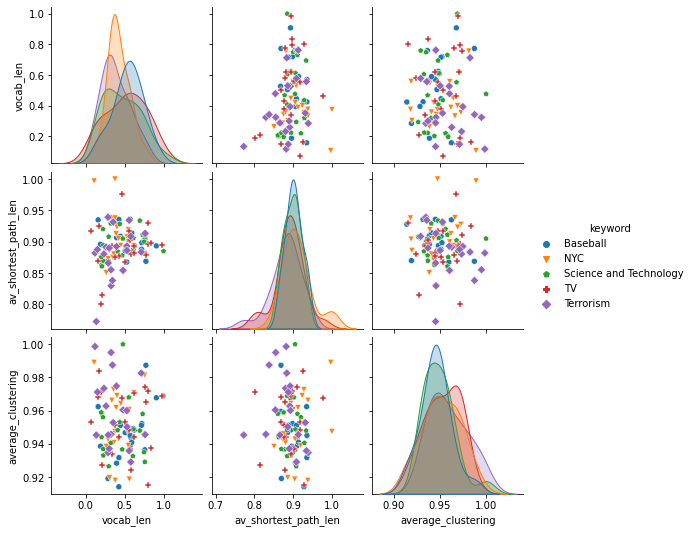

In [90]:
sns.pairplot(dm2, hue='keyword', markers=['o', 'v', 'p', 'P', 'D']);

There might be a slight positive correlation between *average shortest path* and the length of the articles, but it is very weak. Most of the time all the metrics clustered around certain numbers.

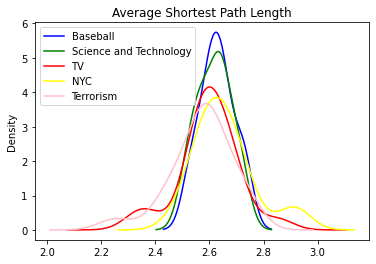

In [91]:
fig, ax = plt.subplots()
(dm.loc[dm['keyword'] == 'Baseball']['av_shortest_path_len']
 .plot.kde(ax=ax, color='blue'))
(dm.loc[dm['keyword'] == 'Science and Technology']['av_shortest_path_len']
 .plot.kde(ax=ax, color='green'))
(dm.loc[dm['keyword'] == 'TV']['av_shortest_path_len']
 .plot.kde(ax=ax, color='red'))
(dm.loc[dm['keyword'] == 'NYC']['av_shortest_path_len']
 .plot.kde(ax=ax, color='yellow'))
(dm.loc[dm['keyword'] == 'Terrorism']['av_shortest_path_len']
 .plot.kde(ax=ax, color='pink'))
plt.legend(['Baseball', 'Science and Technology', 'TV', 'NYC', 'Terrorism'])
plt.title('Average Shortest Path Length');

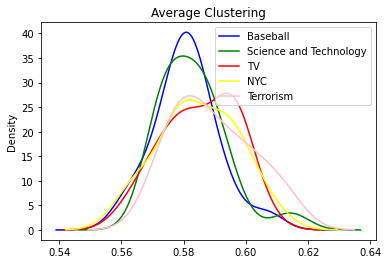

In [92]:
fig, ax = plt.subplots()
(dm.loc[dm['keyword'] == 'Baseball']['average_clustering']
 .plot.kde(ax=ax, color='blue'))
(dm.loc[dm['keyword'] == 'Science and Technology']['average_clustering']
 .plot.kde(ax=ax, color='green'))
(dm.loc[dm['keyword'] == 'TV']['average_clustering']
 .plot.kde(ax=ax, color='red'))
(dm.loc[dm['keyword'] == 'NYC']['average_clustering']
 .plot.kde(ax=ax, color='yellow'))
(dm.loc[dm['keyword'] == 'Terrorism']['average_clustering']
 .plot.kde(ax=ax, color='pink'))
plt.legend(['Baseball', 'Science and Technology', 'TV', 'NYC', 'Terrorism'])
plt.title('Average Clustering');

For now it does not look like the graph metrics could be helpful in clustering the text.

## Comparing Node metrics

In [93]:
udf.head(1)

,abstract,keyword,clean_text,nchunks,vocab,vocab_len,graph,av_shortest_path_len,clustering,average_clustering,vote_rank,eigen_centrality,closeness_centrality,btw_centrality,pagerank
0,A Bronx woman was fatally shot and two of her ...,"[Murders and Homicides, Walikque Faussett, NYP...",bronx woman fatally shot friends wounded early...,"[(a bronx woman, (0, 13)), (her friends, (42, ...","[a bronx woman, was, fatally, shot, and, two, ...",174,"(two, the flatiron district, the three women, ...",2.480367,"{'two': 0.7333333333333333, 'the flatiron dist...",0.576471,"[and, said, was, were, in, to, who, with, on, ...","{'two': 0.05971796541046692, 'the flatiron dis...","{'two': 0.4148681055155875, 'the flatiron dist...","{'two': 0.00046997218953846807, 'the flatiron ...","{'two': 0.0038653458719809975, 'the flatiron d..."


In [94]:
sudf = udf.sort_values(by='vocab_len').copy().reset_index(drop=True)

In [95]:
def sort_metric(ix, column, reverse=True):
    data = sudf.iloc[ix][column]
    # this line filters out stop words
    # it should be removed to see which metrics avoids stop words the most
    pairs = [(k, data[k]) for k in data.keys() if k not in stops]
    return sorted(pairs, key=lambda x: x[1], reverse=reverse)

In [96]:
#ix = np.random.choice(sudf.index, 1)[0]
ix = 0
print(sudf.iloc[ix]['abstract'])

Under pressure from Congress, the television host Dr. Mehmet Oz on Tuesday offered to help “drain the swamp” of unscrupulous marketers using his name to sell so-called miracle pills for weight loss. Dr. Oz, appearing before the Senate’s consumer protection panel, was scolded by the chairwoman, Senator Claire McCaskill, Democrat of Missouri, for his claims about weight-loss aids on “The Dr. Oz Show.” Dr. Oz, a surgeon, acknowledged that his language about green coffee and other supplements had been “flowery.”


Comparing different node metrics and defining, which one helps finding the most important keyphrases in the article.

In [97]:
coefs = ['clustering', 'eigen_centrality', 'closeness_centrality', 
         'btw_centrality', 'pagerank']
# change 'i' to read a result from a different metric
i = 0
sort_metric(ix, coefs[i], reverse=True)[:10]

[('“flowery', 1.0),
 ('pressure', 0.8333333333333334),
 ('the swamp', 0.6666666666666666),
 ('unscrupulous marketers', 0.6666666666666666),
 ('using', 0.6),
 ('weight-loss aids', 0.6),
 ('sell', 0.6),
 ('“drain', 0.6),
 ('offered', 0.6),
 ('his claims', 0.6)]

In [98]:
sudf.loc[ix]['keyword'], sudf.loc[ix]['vote_rank'][:10]

(['Mehmet Oz',
  'Weight',
  'Consumer protection',
  'The Dr. Oz Show',
  'TV',
  'Senate',
  'Congress',
  'Claire McCaskill'],
 ['for',
  '”',
  'about',
  'to',
  'dr. oz',
  'of',
  'on',
  'scolded',
  'congress',
  'other supplements'])

It was curious to see which of the metrics would be able to avoid the stop words and popular words the most. Unfortunately, it is not the case for any of them. *Clustering* prioritises important keyphrases over stop words more, but not good enough to be presented as a complete result. 

In [99]:
%store udf

Stored 'udf' (DataFrame)


### Constructing a semantically aware graph

In this part the same trials are going to be held for the semantic model.

First, word vectors have to be trained.

In [100]:
import fasttext as ft

In [101]:
#%time ft_model = ft.train_unsupervised('../data/data/fil9')

In [102]:
#len(ft_model.words)

In [103]:
#ft_model.save_model("fil9SkipGram.bin")

In [104]:
ft_model = ft.load_model('../models/fil9SkipGram.bin')

In [105]:
ft_model.get_nearest_neighbors('man')

[(0.7125452756881714, 'woman'),
 (0.7092046141624451, 'stranger'),
 (0.7067620754241943, 'stupider'),
 (0.7021083235740662, 'thing'),
 (0.7005878686904907, 'darndest'),
 (0.6971448063850403, 'stupidest'),
 (0.692797839641571, 'beastly'),
 (0.6923372745513916, 'beast'),
 (0.6917076110839844, 'hater'),
 (0.6898659467697144, 'niggardly')]

In [106]:
def get_token_vectors(words, chunks=True):
    
    vectors = OrderedDict()
    for word in words:
        if word not in vectors.keys():
            vectors[word] = ft_model.get_sentence_vector(word)
    array = np.stack(list(vectors.values()), axis=0)
    
    return array, vectors.keys()

def createSemanticGraph(nchunks):
    noun_chunks = list(zip(*nchunks))[0]
    vects, keys = get_token_vectors(noun_chunks, chunks=True)
    sims = cosine_similarity(vects)
    sims_df = pd.DataFrame(sims, columns=keys, index=keys)
    return make_Graph(sims_df, nchunks)

def make_Graph(sims_df, nchunks):
    G = nx.Graph()
    nodes = get_semantic_nodes(sims_df)
    edges = compute_edges(nchunks, nodes)
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    G_attrs = {n: {"name": n , 
                   "words": ' '.join(nodes[n])}
            for n in nodes}

    nx.set_node_attributes(G, G_attrs) 
    return G


def get_semantic_nodes(df, thres=0.8):
    # df should be an nxn matrix with noun chunks being columns and index,
    # and values are similarity matrix
    nodes = OrderedDict()
    for c in df.index:
        neighbours = set(df.loc[c][df[c] >= thres].index)
        if neighbours not in nodes.values():
            nodes[c] = neighbours
    return nodes

def get_node_pairs(semnodes):
    d = semnodes
    node_pairs = dict()
    keys = d.keys()
    for n in keys:
        for n2 in keys:
            if n != n2:
                if (n2, n) not in node_pairs.keys():
                    node_pairs[(n, n2)] = [[i, j] for i in d[n] for j in d[n2]
                                           if i != j]
    
    return node_pairs

def get_chunks_pos(nchunks):
    positions = dict()
    vocabulary = set(list(zip(*nchunks))[0])
    for w in vocabulary:
        if w not in positions.keys():
            positions[w] = [i[1][0] for i in nchunks if i[0] == w]
            
    return positions

def compute_edges(nchunks, semnodes):
    sempairs = get_node_pairs(semnodes)
    scores = []
    pos = get_chunks_pos(nchunks)
    for states_pair in sempairs.keys():
        for words_pair in sempairs[states_pair]:
            w0pos = pos[words_pair[0]]
            w1pos = pos[words_pair[1]]
            score = sum([1/abs(i-j) for i in w0pos for j in w1pos])
            words_pair.append(score)
        edge_score = sum([i[2] for i in sempairs[states_pair]])
        scores.append((*states_pair, edge_score))
    
    return scores    

First trying the semantic approach on one article, to see how well the FastText model can define similarities between the chunks.

In [107]:
short_txt = udf.sort_values(by='vocab_len').iloc[2]

In [108]:
noun_chunks = list(zip(*short_txt['nchunks']))[0]

In [109]:
short_vects, keys = get_token_vectors(noun_chunks, chunks=True)

In [110]:
short_vects.shape, keys

((35, 100),
 odict_keys(['an ashland man', 'model planes', 'explosives', 'the pentagon', 'the united states capitol', 'two charges', 'his lawyers', 'prosecutors', 'a plea agreement', 'federal court', 'tuesday', 'the defendant', 'rezwan ferdaus', 'a physics degree', 'northeastern university', 'boston', 'september', 'federal employees', 'members', 'al qaeda', 'materials', 'grenades', 'machine guns', 'a plastic explosive', 'mr. ferdaus', 'material support', 'terrorists', 'federal buildings', 'the charges', 'a maximum sentence', '35 years', 'prison', 'the defense', 'a 17-year sentence', 'four other charges']))

In [111]:
short_sims = cosine_similarity(short_vects)

In [112]:
short_sims.shape

(35, 35)

Plotting similarity heatmap.

In [113]:
sims_df = pd.DataFrame(short_sims, columns=keys, index=keys)

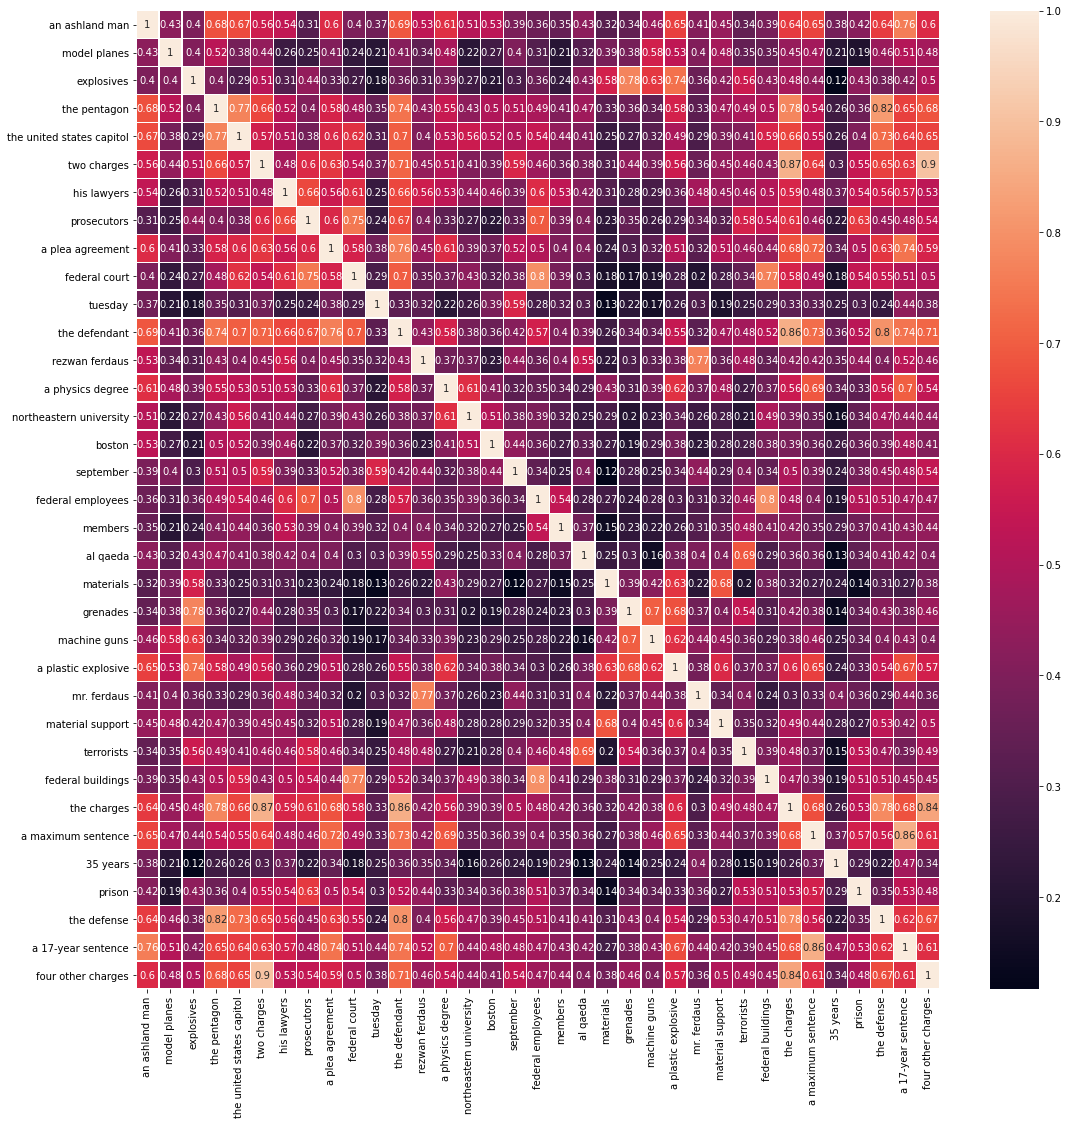

In [114]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(sims_df, annot=True, linewidth=.3);

What is the similarity distribution between the chunks?

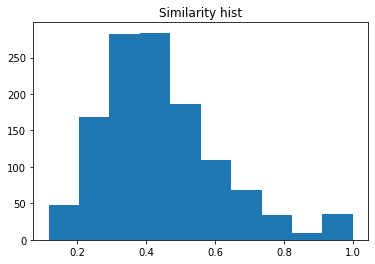

In [115]:
plt.hist(sims_df.values.reshape(sims_df.shape[0]*sims_df.shape[1]))
plt.title('Similarity hist');

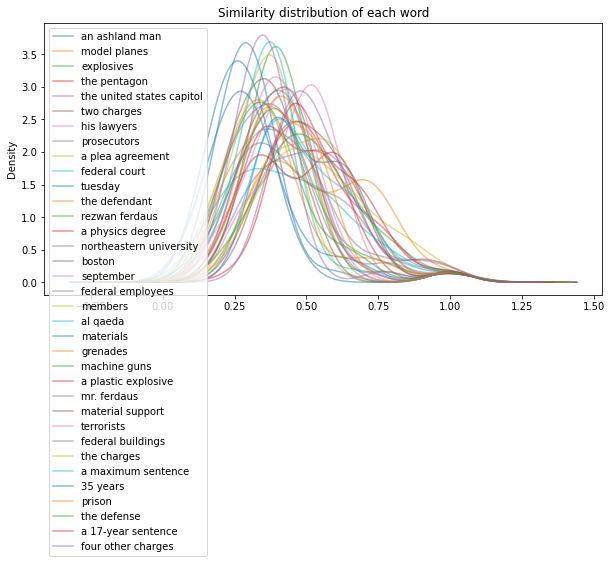

In [116]:
fig, ax = plt.subplots(figsize=(10, 5))

for c in sims_df.index:
    sims_df.loc[c].plot.kde(ax=ax, alpha=0.5)
plt.legend(sims_df.index)
plt.title('Similarity distribution of each word');

Some words have more similarity with all the other words than the other, but in general their similarity all cluster around 0.5.

In [117]:
sims_df.head(1)

,an ashland man,model planes,explosives,the pentagon,the united states capitol,two charges,his lawyers,prosecutors,a plea agreement,federal court,...,material support,terrorists,federal buildings,the charges,a maximum sentence,35 years,prison,the defense,a 17-year sentence,four other charges
an ashland man,1.0,0.427545,0.396263,0.6784,0.668569,0.563544,0.535097,0.314563,0.604832,0.397857,...,0.450676,0.342134,0.389027,0.636836,0.653431,0.381895,0.419662,0.637848,0.761255,0.601693


Now computing the same graph metrics for a semantic model.

In [118]:
dfm = udf.copy()

In [119]:
#%pdb on

In [120]:
dfm.head(1)

,abstract,keyword,clean_text,nchunks,vocab,vocab_len,graph,av_shortest_path_len,clustering,average_clustering,vote_rank,eigen_centrality,closeness_centrality,btw_centrality,pagerank
0,A Bronx woman was fatally shot and two of her ...,"[Murders and Homicides, Walikque Faussett, NYP...",bronx woman fatally shot friends wounded early...,"[(a bronx woman, (0, 13)), (her friends, (42, ...","[a bronx woman, was, fatally, shot, and, two, ...",174,"(two, the flatiron district, the three women, ...",2.480367,"{'two': 0.7333333333333333, 'the flatiron dist...",0.576471,"[and, said, was, were, in, to, who, with, on, ...","{'two': 0.05971796541046692, 'the flatiron dis...","{'two': 0.4148681055155875, 'the flatiron dist...","{'two': 0.00046997218953846807, 'the flatiron ...","{'two': 0.0038653458719809975, 'the flatiron d..."


In [121]:
dfm = dfm.drop(['vocab', 'vocab_len', 'graph',
                'av_shortest_path_len', 'clustering',
                'average_clustering', 'vote_rank',
                'eigen_centrality', 'closeness_centrality', 
                'btw_centrality', 'pagerank'],
               axis=1)

In [122]:
dfm.head(1)

,abstract,keyword,clean_text,nchunks
0,A Bronx woman was fatally shot and two of her ...,"[Murders and Homicides, Walikque Faussett, NYP...",bronx woman fatally shot friends wounded early...,"[(a bronx woman, (0, 13)), (her friends, (42, ..."


Computing semantic graph for each article.

In [123]:
%time dfm['graph'] = dfm.loc[:, 'nchunks'].apply(createSemanticGraph)

CPU times: user 46.3 s, sys: 2.15 s, total: 48.5 s
Wall time: 44.6 s


In [124]:
dfm.columns

Index(['abstract', 'keyword', 'clean_text', 'nchunks', 'graph'], dtype='object')

# Centrality

In [125]:
%%time
dfm['clustering'] = (dfm.loc[:, 'graph']
                     .apply(lambda x: nx.clustering(x, weight='weight')))

CPU times: user 6min 38s, sys: 2.83 ms, total: 6min 38s
Wall time: 6min 38s


### Eigenvector Centrality

In [126]:
def eigen_centrality(G):
    return nx.eigenvector_centrality(G, max_iter=500, weight='weight')

In [127]:
%time dfm['eigen_centrality'] = dfm.loc[:, 'graph'].apply(eigen_centrality)

CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 14.8 s


### Closeness Centrality

In [128]:
%%time
dfm['closeness_centrality'] = (dfm.loc[:, 'graph']
                               .apply(
                                   lambda G: nx.closeness_centrality(G,
                                                                     distance='weight') 
                               ))

CPU times: user 2min 23s, sys: 11.2 ms, total: 2min 23s
Wall time: 2min 23s


### Betweenness Centrality


In [129]:
%%time
dfm['btw_centrality'] = (dfm.loc[:, 'graph']
                         .apply(
                             lambda G: nx.betweenness_centrality(G,
                                                                 weight='weight')
                         ))

CPU times: user 2min 59s, sys: 3.3 ms, total: 2min 59s
Wall time: 2min 59s


### PageRank

In [130]:
%%time
dfm['pagerank'] = (dfm.loc[:, 'graph']
                         .apply(
                             lambda G: nx.pagerank(G, weight='weight')
                         ))

CPU times: user 19.4 s, sys: 136 ms, total: 19.5 s
Wall time: 19.5 s


## Comparing Node metrics

In [131]:
dfm.head(1)

,abstract,keyword,clean_text,nchunks,graph,clustering,eigen_centrality,closeness_centrality,btw_centrality,pagerank
0,A Bronx woman was fatally shot and two of her ...,"[Murders and Homicides, Walikque Faussett, NYP...",bronx woman fatally shot friends wounded early...,"[(a bronx woman, (0, 13)), (her friends, (42, ...","(a bronx woman, her friends, a man, a manhatta...","{'a bronx woman': 0.09474294857696097, 'her fr...","{'a bronx woman': 0.21980821655901037, 'her fr...","{'a bronx woman': 62.75107582732688, 'her frie...","{'a bronx woman': 0.0, 'her friends': 0.0, 'a ...","{'a bronx woman': 0.03093343428724658, 'her fr..."


In [132]:
dfm['vocab_len'] = dfm.loc[:, 'clean_text'].apply(lambda x: len(x.split()))

In [133]:
dfm = dfm.sort_values(by='vocab_len')

In [134]:
dfm.head(1)

,abstract,keyword,clean_text,nchunks,graph,clustering,eigen_centrality,closeness_centrality,btw_centrality,pagerank,vocab_len
87,"Under pressure from Congress, the television h...","[Mehmet Oz, Weight, Consumer protection, The D...",pressure congress television host dr mehmet oz...,"[(pressure, (6, 14)), (congress, (20, 28)), (t...","(pressure, congress, the television host, dr. ...","{'pressure': 0.06166659096479958, 'congress': ...","{'pressure': 0.09393264768594352, 'congress': ...","{'pressure': 161.27603008116608, 'congress': 1...","{'pressure': 0.33766233766233766, 'congress': ...","{'pressure': 0.028764027330858182, 'congress':...",51


In [135]:
def sort_metric2(ix, column, reverse=True):
    data = dfm.iloc[ix][column]
    pairs = [(k, data[k]) for k in data.keys() if k not in stops]
    return sorted(pairs, key=lambda x: x[1], reverse=reverse)

In [136]:
#ix = np.random.choice(dfm.index, 1)[0]
ix = 0
print(dfm.iloc[ix]['abstract'])

Under pressure from Congress, the television host Dr. Mehmet Oz on Tuesday offered to help “drain the swamp” of unscrupulous marketers using his name to sell so-called miracle pills for weight loss. Dr. Oz, appearing before the Senate’s consumer protection panel, was scolded by the chairwoman, Senator Claire McCaskill, Democrat of Missouri, for his claims about weight-loss aids on “The Dr. Oz Show.” Dr. Oz, a surgeon, acknowledged that his language about green coffee and other supplements had been “flowery.”


In [137]:
coefs = ['eigen_centrality', 
         'closeness_centrality', 'btw_centrality',
         'pagerank']
sort_metric2(ix, coefs[0], reverse=True)[:10]

[('dr. oz', 0.45511498329671524),
 ('“the dr. oz show', 0.4018570788282476),
 ('a surgeon', 0.35619372344654365),
 ('dr. mehmet oz', 0.3543228181294027),
 ('weight loss', 0.22280095487792606),
 ('weight-loss aids', 0.20126776581165778),
 ('his claims', 0.16988566333787108),
 ('missouri', 0.15784695072656224),
 ('the senate’s consumer protection panel', 0.1507943586617867),
 ('his language', 0.14639180141232866)]

Comparing word co-occurence approach with semantic approach.

In [138]:
coefs = ['eigen_centrality', 
         'closeness_centrality', 'btw_centrality',
         'pagerank', 'clustering']
method = coefs[4]
semdf = pd.DataFrame(sort_metric2(ix, method, reverse=True)[:10],
                    columns=['sem_word', 'sem_score'])
ocdf = pd.DataFrame(sort_metric(ix, method, reverse=True)[:10],
                    columns=['oc_word', 'oc_score'])
pd.concat([semdf, ocdf], axis=1)

,sem_word,sem_score,oc_word,oc_score
0,dr. oz,0.198818,“flowery,1.000000
1,dr. mehmet oz,0.167043,pressure,0.833333
2,“the dr. oz show,0.164219,the swamp,0.666667
3,a surgeon,0.096799,unscrupulous marketers,0.666667
4,weight loss,0.090811,using,0.600000
5,weight-loss aids,0.088458,weight-loss aids,0.600000
6,his claims,0.087268,sell,0.600000
7,missouri,0.086609,“drain,0.600000
8,democrat,0.083999,offered,0.600000
9,the senate’s consumer protection panel,0.080775,his claims,0.600000


It looks like the nodes constructed semantically are more informative. But they only contain nouns and miss the important information the verbs provide. In the future the combination of semantic noun chunks and verb subtrees should be considered. It is also important to note that the keyphrases from semantic model listed here are only the *names of the nodes*. As it was mentioned, each node in the semantic model contains many similar chunks. In the end, after the nodes are ranked, the most informative subphrase could be chosen to make a final output even more informative. 

Visualising both graphs

In [139]:
title = sudf.iloc[0]['abstract']
graph = sudf.iloc[0]['graph']
show_bokeh_graph(title, graph, 'text', 'degree')

In [140]:
title = dfm.iloc[0]['abstract']
graph = dfm.iloc[0]['graph']
show_bokeh_graph(title, graph, 'words', 'name')

***Plan for future improvements:***

1. Add verbs or syntactic ngrams to the semantic model. 
2. Add syntactic or dependency relations (plotted below) to the semantic model.


In [141]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/masha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [142]:
import benepar
benepar.download('benepar_en2')

[nltk_data] Downloading package benepar_en2 to
[nltk_data]     /home/masha/nltk_data...
[nltk_data]   Package benepar_en2 is already up-to-date!


True

In [143]:
parser = benepar.Parser("benepar_en2")

In [144]:
s = "The main challenges of Seq2Seq methods "\
     "lie in better modeling "\
     "the compositionality of the target keyphrases set. "\
     "which will directly affect the quality of generated "\
     "keyphrases."

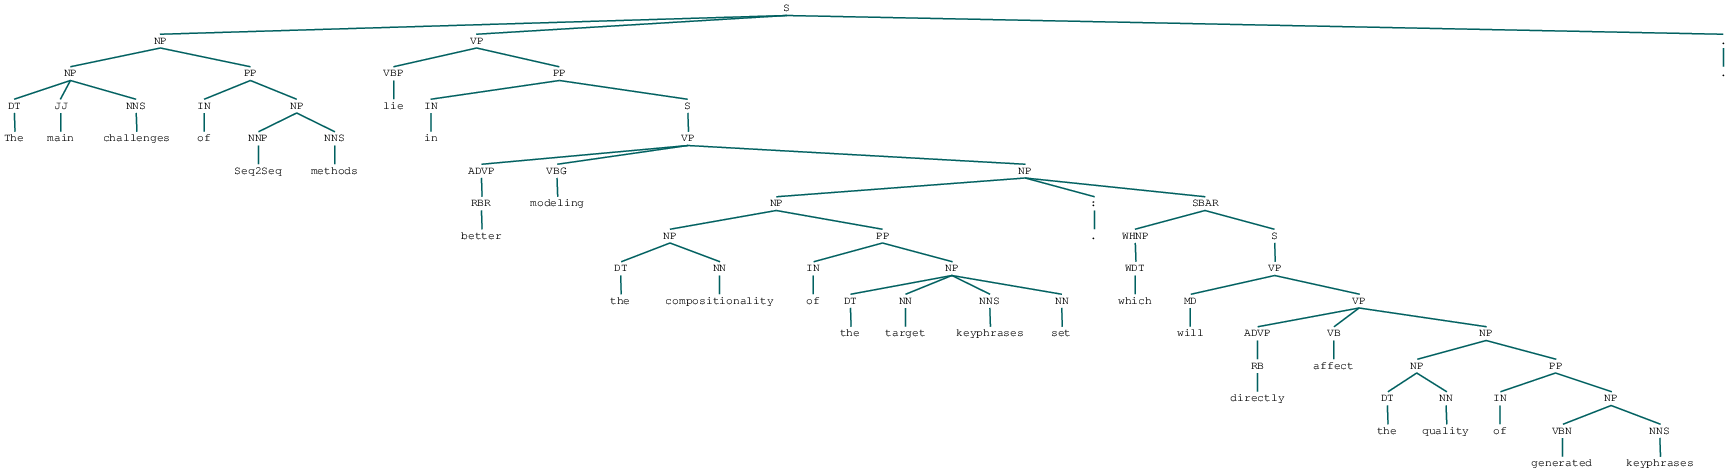

In [145]:
parser.parse(s)

In [146]:
from spacy import displacy

In [147]:
doc = nlp(s)

In [148]:
options = {
    'compact': True,
}
displacy.render(doc, style="dep",
                options=options)